#GPU information

In [1]:
! nvidia-smi

#Directory, packages, and fix seeds

In [1]:
import os
from google.colab import drive
import sys

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir(path = '/content/drive/My Drive/master_thesis/MasterThesisAniss_clearercode/')
#print(os.listdir())

In [4]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from callers import *

In [6]:
np.random.seed(42) # fix the seed of numpy for example to split the dataset in the same way
torch.manual_seed(1) #1 # fix the seed of torch to be able to repeat the experiments with the same initialization of the neural networks. (Notice that for some torch seed like equal to 2, it seems to have a problem for a Cheloseky Decomposition needed in the VAE with GMM prior, so just change the torch seed here)

#Define the dataset, train = (matrix X, colors)

In [7]:
# import/create the dataset here

##dataset = datasets.SimpleCylinder
#dataset = datasets.Cylinder().sample(5000, height = 20, width = 1, radius = 7, noise = 0)

dataset = datasets.SwissRoll().sample(5000)

In [8]:
# split the data into train, validation, test
train, validation, test = split(dataset, 0.6, 0.2, 0.2, True)

In [9]:
# print the shapes
print(train[0].shape, validation[0].shape, test[0].shape)

(3000, 3) (1000, 3) (1000, 3)


In [10]:
X = train[0] # dataset without the colors
id_X = [ i for i in range(X.shape[0])] # to identify each data point to facilitate the use of Witness Complex later on

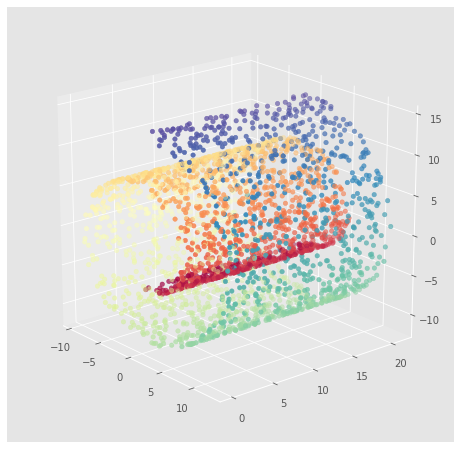

In [11]:
plot_dataset_3d(train)

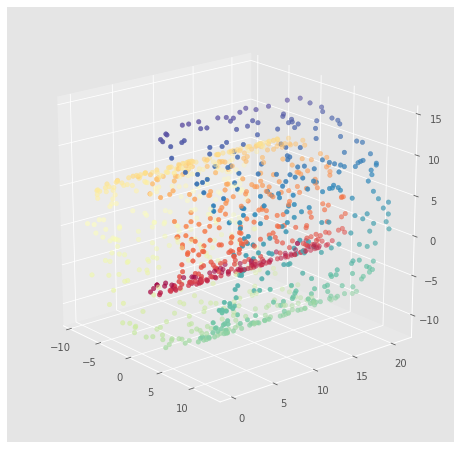

In [12]:
plot_dataset_3d(test)

In [13]:
# create the sub-datasets into torch format
train_ = torch.utils.data.TensorDataset(cuda(train[0]), cuda(train[1]), cuda(id_X))
validation_ = torch.utils.data.TensorDataset(cuda(validation[0]), cuda(validation[1]))
test_ = torch.utils.data.TensorDataset(cuda(test[0]), cuda(test[1]))

In [14]:
# create the dataloaders for each sub-datasets into some batches

batch_size = 128 ##256 #128 #32

DataLoaderTrain = torch.utils.data.DataLoader(dataset = train_, batch_size = batch_size, shuffle = True)
DataLoaderValidation = torch.utils.data.DataLoader(dataset = validation_, batch_size = batch_size, shuffle = True)
DataLoaderTest = torch.utils.data.DataLoader(dataset = test_, batch_size = batch_size, shuffle = True)

#Dimensionality reduction: UMAP, ISOMAP

In [ ]:
n_neighbors_embedding = 100 #20
random_state_embedding = 42
min_dist_umap = 1.0 #0.1

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


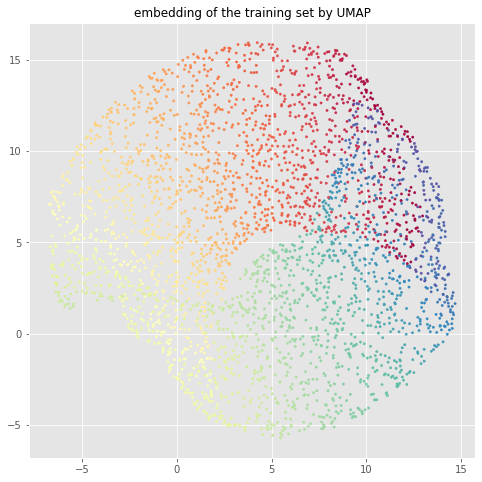

In [ ]:
UMAP_ = UMAP(n_neighbors=n_neighbors_embedding, min_dist=min_dist_umap, random_state=random_state_embedding).fit(X)
plot_embedding_2d(instance = UMAP_, dataset = train)

In [ ]:
### To plot the connectivity of the UMAP embedding

#! pip install umap-learn[plot]
#import umap.plot
#umap.plot.connectivity(UMAP_, show_points=True)

## umap.plot.connectivity(UMAP_, edge_bundling='hammer') # too long

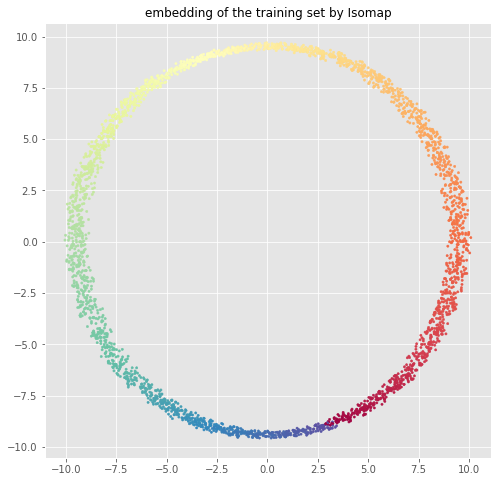

In [ ]:
ISOMAP_ = ISOMAP(n_neighbors=n_neighbors_embedding, n_components=2)
ISOMAP_.embedding_ = ISOMAP_.fit_transform(X)
plot_embedding_2d(instance = ISOMAP_, dataset = train)

In [ ]:
TSNE_ = TSNE(n_components=2)
TSNE_.embedding_ = TSNE_.fit_transform(X)
plot_embedding_2d(instance = TSNE_, dataset = train)

#Build the GMM (Gaussian Mixture Model) prior from one embedding, to be used in a VAE with GMM prior

In [ ]:
#Z_embedding = UMAP_.embedding_
Z_embedding = ISOMAP_.embedding_

In [ ]:
number_of_gaussians_components = 4    # Better to choose a number lower or equal to 8

GMM = sklearn.mixture.GaussianMixture
GMM_ = mixture.GaussianMixture(n_components=number_of_gaussians_components, covariance_type='diag')
GMM_.fit(Z_embedding)
weights_prior, means_prior, covariances_prior = cuda(GMM_.weights_), cuda(GMM_.means_), cuda(GMM_.covariances_)

In [ ]:
# display predicted scores by the model as a contour plot

from matplotlib.colors import LogNorm
#plt.style.use('classic')

plt.figure(figsize = (8, 6))

epsilon = 3
xGMM = np.linspace(min(Z_embedding[:, 0])-epsilon, max(Z_embedding[:, 0])+epsilon)
yGMM = np.linspace(min(Z_embedding[:, 1])-epsilon, max(Z_embedding[:, 1])+epsilon)
XGMM, YGMM = np.meshgrid(xGMM, yGMM)
XXGMM = np.array([XGMM.ravel(), YGMM.ravel()]).T
ZGMM = -GMM_.score_samples(XXGMM)
ZGMM = ZGMM.reshape(XGMM.shape)

CS = plt.contour(XGMM, YGMM, ZGMM, levels=np.linspace(ZGMM.min(), ZGMM.max(), 100))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(Z_embedding[:, 0], Z_embedding[:, 1], c=train[1])

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

#Build the Fuzzy simplicial complex, from one embedding and/or directly from the input data space (i.e. without needing to do the dimensionality reduction)

In [ ]:
n_neighbors_embedding = 10
random_state_embedding = 42
dim_latent_space = 2

In [ ]:
### If using Z_embedding for the simplicial regularization:

graphZ = umap_.fuzzy_simplicial_set(X=Z_embedding, n_neighbors=n_neighbors_embedding, random_state=np.random.RandomState(random_state_embedding), metric='euclidean')[0]
#plot_graph(Z_embedding, graphZ)
alphasZ = find_cut_alphas(graphZ.data, max_cuts=10, make_plots=False)
listKZ = create_simplicial_complex(graphZ, max_dim=Z_embedding.shape[1], verbose=False, cut_alpha = alphasZ[int(0.6 * len(alphasZ))])
dictKZ = flatten_complex(listKZ)

dictKZkeys = list(dictKZ.keys())
dictKZvalues = list(dictKZ.values())

## Scale the probas of dictKZ:
sum_probas_top = sum(dictKZvalues)
for key in dictKZkeys:
  dictKZ[key]=dictKZ[key]/sum_probas_top
dictKZvalues = list(dictKZ.values())

In [ ]:
### Without using any embedding for the simplicial regularization, building the Fuzzy simplical complex directly from the input data space

graphX = umap_.fuzzy_simplicial_set(X=X, n_neighbors=n_neighbors_embedding, random_state=np.random.RandomState(random_state_embedding), metric='euclidean')[0]
alphasX = find_cut_alphas(graphX.data, max_cuts=10, make_plots=False)
# Only use edges withing the top 50% strength:
listKX = create_simplicial_complex(graphX, max_dim=dim_latent_space, verbose=False, cut_alpha = alphasX[int(0.6 * len(alphasX))])
dictKX = flatten_complex(listKX)

dictKXkeys = list(dictKX.keys())
dictKXvalues = list(dictKX.values())

## Scale the probas of dictKX:
sum_probas_top = sum(dictKXvalues)
for key in dictKXkeys:
  dictKX[key]=dictKX[key]/sum_probas_top
dictKXvalues = list(dictKX.values())

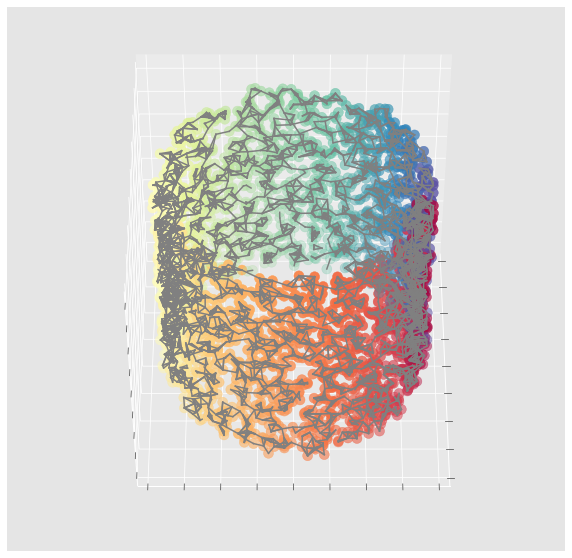

In [ ]:
plot_1simplices(train[0], dictKXkeys, train[1], 50, 0)

#Build the Witness Complex directly from the input data space
To be used for the Witness Simplicial VAEs.

In [15]:
!pip install gudhi
from witness_complex import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


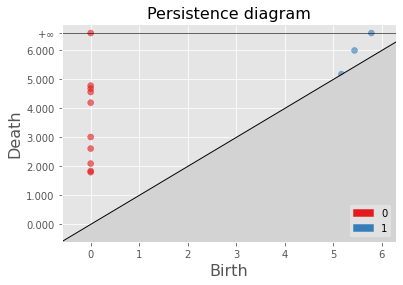

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Witness Complex:  [[1, 3], [2, 6], [3, 9], [3, 1], [9, 1], [3, 9, 1], [4, 5], [5, 4], [6, 2], [7, 9], [9, 3], [9, 7], [3, 7], [9, 3, 7], [7, 0], [4, 2], [8, 2], [0, 7], [1, 2], [7, 3], [9, 7, 3], [0, 5], [8, 5], [8, 4], [8, 5, 4], [5, 0], [7, 3, 9], [3, 9, 7], [1, 9], [3, 1, 9], [2, 1], [2, 4], [1, 6], [5, 8], [6, 1], [2, 6, 1], [1, 6, 2], [4, 8], [4, 5, 8], [3, 7, 9], [7, 9, 3], [2, 8], [5, 4, 8], [6, 2, 1], [6, 1, 2], [4, 8, 5], [5, 8, 4], [2, 1, 6], [8, 4, 5], [5, 2], [4, 5, 2], [1, 2, 6], [2, 5], [4, 2, 5], [4, 8, 2]]
Number of simplices in the Witness Complex:  55
One view of the Witness Complex showing only the landmarks:


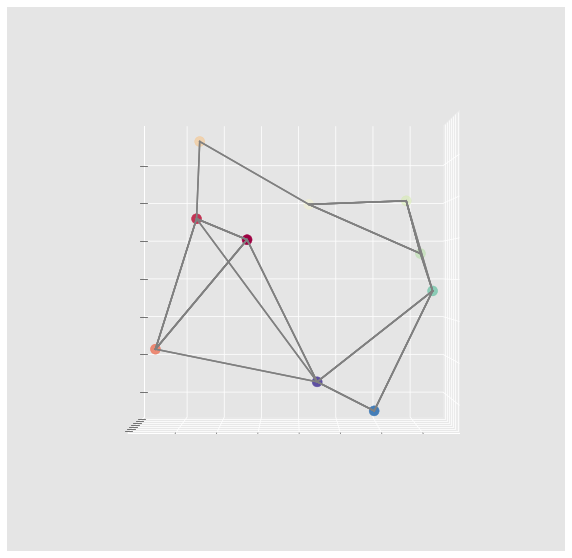

Another view of this Witness Complex showing only the landmarks:


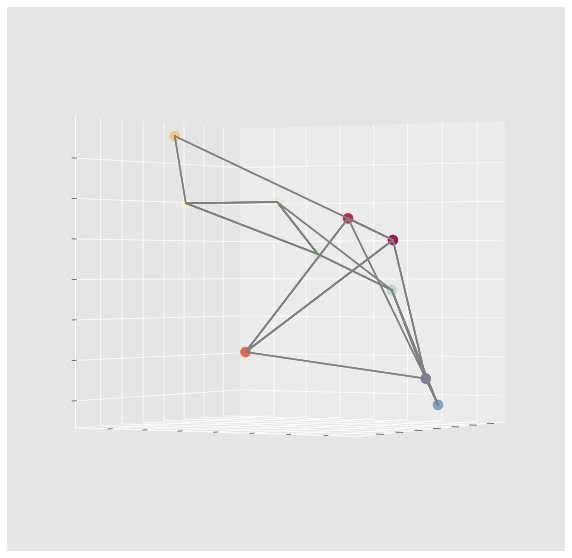

Another view of this Witness Complex showing all the points:


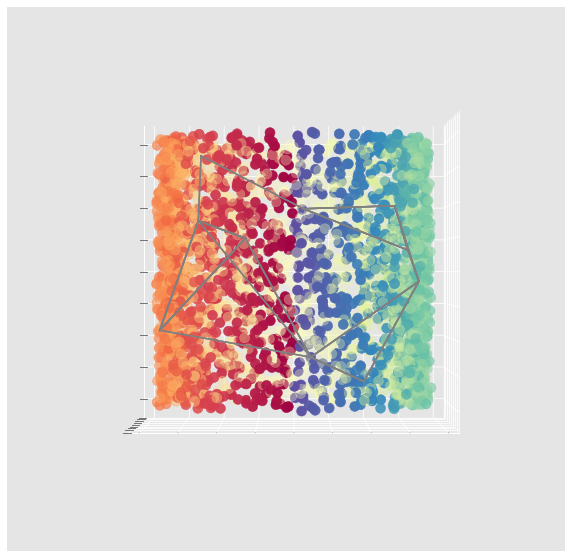

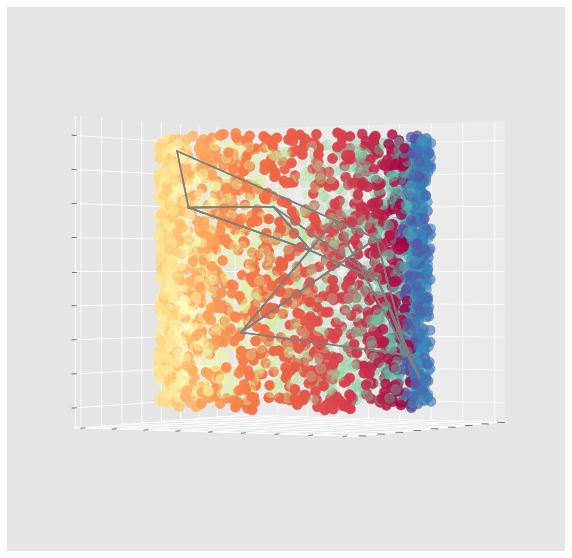

In [ ]:
# Exploring one specific Witness Complex

witnesses = X
landmark_sup = 10 #10 #32
landmarks = X[:landmark_sup,:]
chosen_r_max = 6 # Maximum filtration radius value, should be chosen as being the smallest and high enough radius so that you get a relevant Witness Complex. For example if you want to preserve Betti number 1 (the 1-dimensional whole), you could start with a high value, see the Persitence Diagram and then choose the relevant radius and build again the relevant Witness Complex using this radius.
chosen_d_max = 2 # Maximum dimension of the Witness Complex, should be equal (or smaller) to the dimension of the latent space of the VAE for using the simplicial regularization.

wc2 = WitnessComplex(landmarks,witnesses)
wc2.compute_simplicial_complex(d_max=chosen_d_max,create_simplex_tree=True,create_metric=True, r_max=chosen_r_max, n_jobs=2)
#simplex_tree = wc2.simplex_tree #how to retrieve the simplex_tree
wc2.get_diagram(show=True,path_to_save=None) # allows to directly plot a persistence diagram

K_witnesscomplex = [] # !! This will have the indices of the simplices but with regard to their place in landmarks, change by retrieving the indices in X !!
for i in range(np.shape(wc2.simplicial_complex)[0]):
  if len(wc2.simplicial_complex[i][0]) > 1 and wc2.simplicial_complex[i][0] not in K_witnesscomplex: #simplices of dim>1 and without repetition
    K_witnesscomplex.append(wc2.simplicial_complex[i][0])
    
print('Witness Complex: ',K_witnesscomplex)
print('Number of simplices in the Witness Complex: ',len(K_witnesscomplex))

selected_colors = train[1][:landmark_sup]

# print('One view of the Witness Complex showing only the landmarks:')
# plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 90, 0)
# print('Another view of this Witness Complex showing only the landmarks:')
# #plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 0, 0)
# plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 60, 0)
# print('Another view of this Witness Complex showing all the points:')
# plot_1simplices(X, K_witnesscomplex, train[1], 90, 0)
# #plot_1simplices(X, K_witnesscomplex, train[1], 0, 90)
# plot_1simplices(X, K_witnesscomplex, train[1], 60, 0)

print('One view of the Witness Complex showing only the landmarks:')
plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 0, 90)
print('Another view of this Witness Complex showing only the landmarks:')
#plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 0, 0)
plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 0, 30)
print('Another view of this Witness Complex showing all the points:')
plot_1simplices(X, K_witnesscomplex, train[1], 0, 90)
plot_1simplices(X, K_witnesscomplex, train[1], 0, 30)

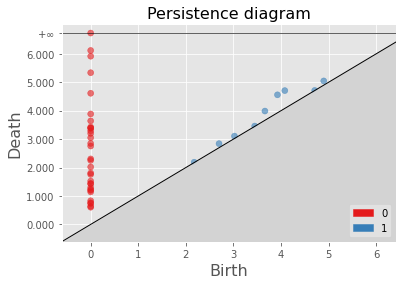

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Witness Complex:  [[1, 12], [1, 27], [12, 27], [1, 12, 27], [2, 15], [2, 31], [15, 31], [2, 15, 31], [2, 28], [15, 28], [2, 15, 28], [31, 28], [2, 31, 28], [15, 31, 28], [2, 21], [15, 21], [2, 15, 21], [31, 21], [2, 31, 21], [15, 31, 21], [28, 21], [2, 28, 21], [15, 28, 21], [31, 28, 21], [3, 16], [3, 17], [16, 17], [3, 16, 17], [3, 4], [16, 4], [3, 16, 4], [17, 4], [3, 17, 4], [16, 17, 4], [3, 11], [16, 11], [3, 16, 11], [17, 11], [3, 17, 11], [16, 17, 11], [4, 11], [3, 4, 11], [16, 4, 11], [17, 4, 11], [4, 3], [11, 3], [4, 11, 3], [4, 16], [11, 16], [4, 11, 16], [4, 3, 16], [11, 3, 16], [5, 18], [6, 22], [6, 21], [22, 21], [6, 22, 21], [6, 28], [22, 28], [6, 22, 28], [21, 28], [6, 21, 28], [22, 21, 28], [6, 20], [22, 20], [6, 22, 20], [21, 20], [6, 21, 20], [22, 21, 20], [28, 20], [6, 28, 20], [22, 28, 20], [21, 28, 20], [7, 9], [7, 30], [9, 30], [7, 9, 30], [8, 26], [9, 7], [30, 7], [9, 30, 7], [9, 10], [30, 10], [9, 30, 10], [7, 10], [9, 7, 10], [30, 7, 10], [9, 24], [30, 24], [9, 

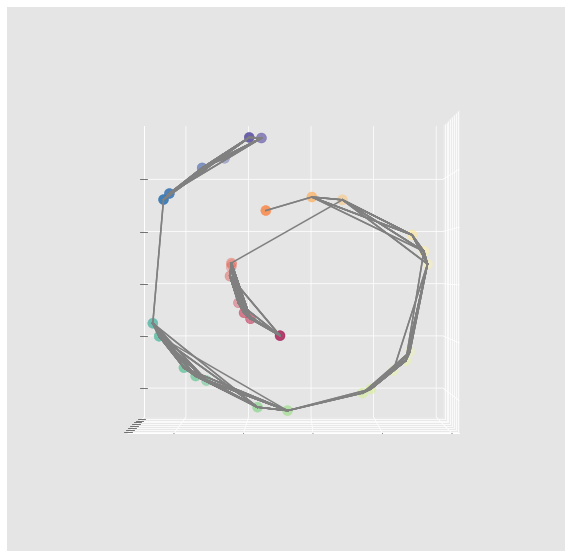

Another view of this Witness Complex showing only the landmarks:


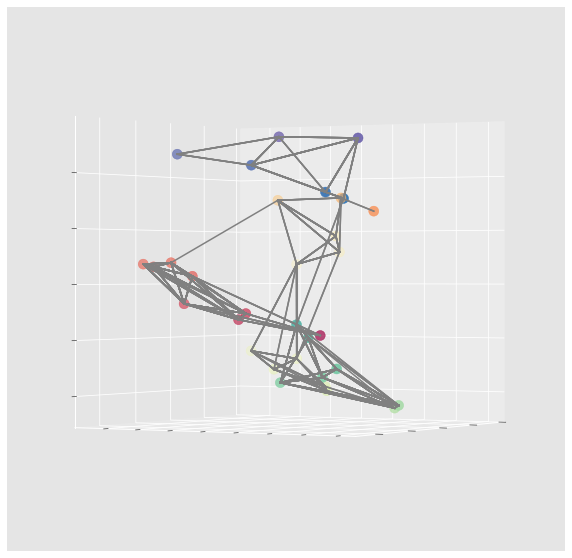

Another view of this Witness Complex showing all the points:


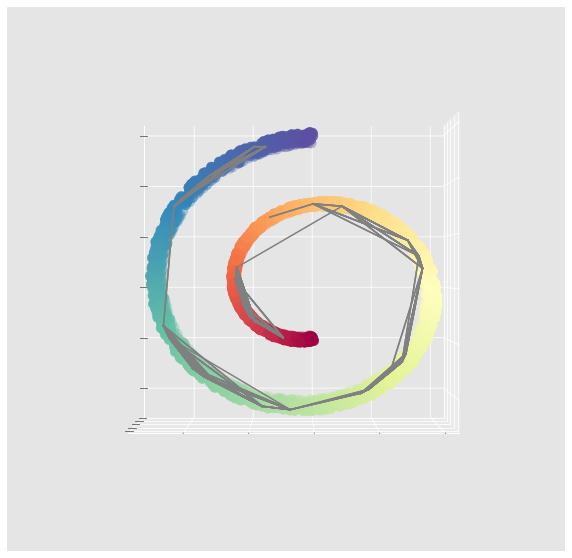

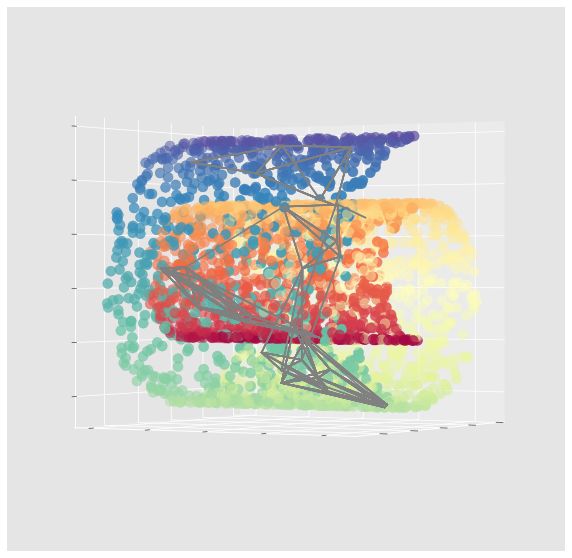

In [16]:
# Exploring one specific Witness Complex

witnesses = X
landmark_sup = 32 #10 #32
landmarks = X[:landmark_sup,:]
chosen_r_max = 6.12 # Maximum filtration radius value, should be chosen as being the smallest and high enough radius so that you get a relevant Witness Complex. For example if you want to preserve Betti number 1 (the 1-dimensional whole), you could start with a high value, see the Persitence Diagram and then choose the relevant radius and build again the relevant Witness Complex using this radius.
chosen_d_max = 2 # Maximum dimension of the Witness Complex, should be equal (or smaller) to the dimension of the latent space of the VAE for using the simplicial regularization.

wc2 = WitnessComplex(landmarks,witnesses)
wc2.compute_simplicial_complex(d_max=chosen_d_max,create_simplex_tree=True,create_metric=True, r_max=chosen_r_max, n_jobs=2)
#simplex_tree = wc2.simplex_tree #how to retrieve the simplex_tree
wc2.get_diagram(show=True,path_to_save=None) # allows to directly plot a persistence diagram

K_witnesscomplex = [] # !! This will have the indices of the simplices but with regard to their place in landmarks, change by retrieving the indices in X !!
for i in range(np.shape(wc2.simplicial_complex)[0]):
  if len(wc2.simplicial_complex[i][0]) > 1 and wc2.simplicial_complex[i][0] not in K_witnesscomplex: #simplices of dim>1 and without repetition
    K_witnesscomplex.append(wc2.simplicial_complex[i][0])
    
print('Witness Complex: ',K_witnesscomplex)
print('Number of simplices in the Witness Complex: ',len(K_witnesscomplex))

selected_colors = train[1][:landmark_sup]

# print('One view of the Witness Complex showing only the landmarks:')
# plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 90, 0)
# print('Another view of this Witness Complex showing only the landmarks:')
# #plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 0, 0)
# plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 60, 0)
# print('Another view of this Witness Complex showing all the points:')
# plot_1simplices(X, K_witnesscomplex, train[1], 90, 0)
# #plot_1simplices(X, K_witnesscomplex, train[1], 0, 90)
# plot_1simplices(X, K_witnesscomplex, train[1], 60, 0)

print('One view of the Witness Complex showing only the landmarks:')
plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 0, 90)
print('Another view of this Witness Complex showing only the landmarks:')
#plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 0, 0)
plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 0, 30)
print('Another view of this Witness Complex showing all the points:')
plot_1simplices(X, K_witnesscomplex, train[1], 0, 90)
plot_1simplices(X, K_witnesscomplex, train[1], 0, 30)

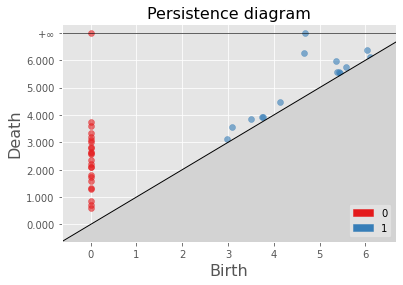

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Witness Complex:  [[0, 19], [0, 13], [19, 13], [0, 19, 13], [0, 18], [19, 18], [0, 19, 18], [13, 18], [0, 13, 18], [19, 13, 18], [1, 23], [1, 3], [23, 3], [1, 23, 3], [2, 6], [3, 9], [3, 12], [9, 12], [3, 9, 12], [3, 1], [9, 1], [3, 9, 1], [12, 1], [3, 12, 1], [9, 12, 1], [3, 14], [9, 14], [3, 9, 14], [12, 14], [3, 12, 14], [9, 12, 14], [1, 14], [3, 1, 14], [9, 1, 14], [12, 1, 14], [4, 16], [4, 5], [16, 5], [4, 16, 5], [4, 11], [16, 11], [4, 16, 11], [5, 11], [4, 5, 11], [16, 5, 11], [4, 10], [16, 10], [4, 16, 10], [5, 10], [4, 5, 10], [16, 5, 10], [11, 10], [4, 11, 10], [16, 11, 10], [5, 11, 10], [5, 16], [11, 16], [5, 11, 16], [5, 4], [11, 4], [5, 11, 4], [16, 4], [5, 16, 4], [11, 16, 4], [6, 2], [6, 23], [2, 23], [6, 2, 23], [7, 18], [7, 13], [18, 13], [7, 18, 13], [7, 9], [18, 9], [7, 18, 9], [13, 9], [7, 13, 9], [18, 13, 9], [8, 15], [8, 20], [15, 20], [8, 15, 20], [9, 3], [14, 3], [9, 14, 3], [9, 7], [14, 7], [9, 14, 7], [3, 7], [9, 3, 7], [14, 3, 7], [14, 12], [9, 14, 12], [9, 3

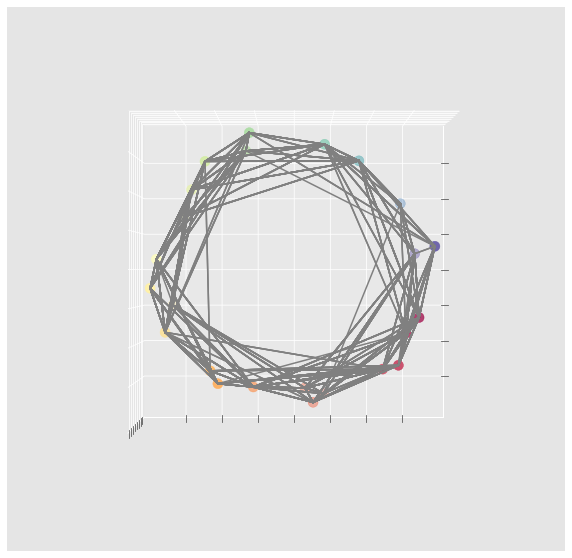

Another view of this Witness Complex showing only the landmarks:


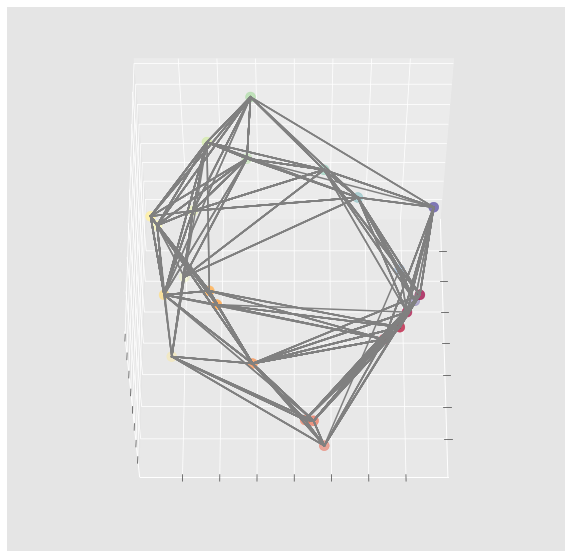

Another view of this Witness Complex showing all the points:


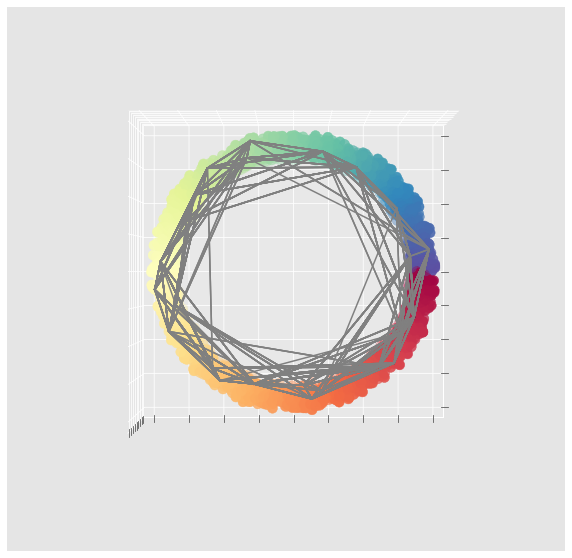

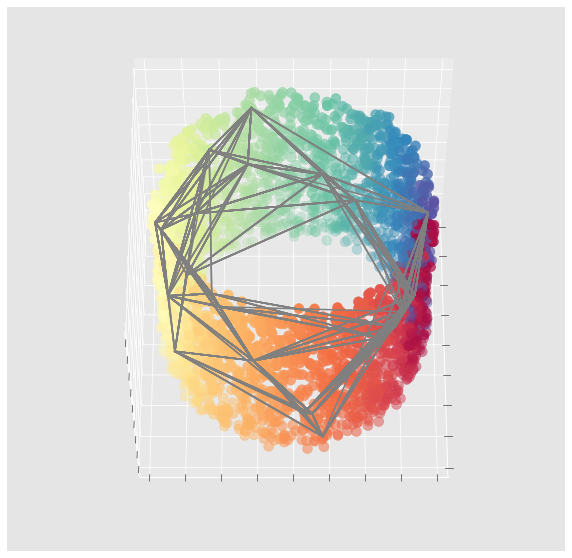

In [ ]:
# Example for exploring one specific Witness Complex

witnesses = X
landmark_sup = 24 #32
landmarks = X[:landmark_sup,:]
chosen_r_max = 6.5 # Maximum filtration radius value, should be chosen as being the smallest and high enough radius so that you get a relevant Witness Complex. For example if you want to preserve Betti number 1 (the 1-dimensional whole), you could start with a high value, see the Persitence Diagram and then choose the relevant radius and build again the relevant Witness Complex using this radius.
chosen_d_max = 2 # Maximum dimension of the Witness Complex, should be equal (or smaller) to the dimension of the latent space of the VAE for using the simplicial regularization.

wc2 = WitnessComplex(landmarks,witnesses)
wc2.compute_simplicial_complex(d_max=chosen_d_max,create_simplex_tree=True,create_metric=True, r_max=chosen_r_max, n_jobs=2)
#simplex_tree = wc2.simplex_tree #how to retrieve the simplex_tree
wc2.get_diagram(show=True,path_to_save=None) # allows to directly plot a persistence diagram

K_witnesscomplex = [] # !! This will have the indices of the simplices but with regard to their place in landmarks, change by retrieving the indices in X !!
for i in range(np.shape(wc2.simplicial_complex)[0]):
  if len(wc2.simplicial_complex[i][0]) > 1 and wc2.simplicial_complex[i][0] not in K_witnesscomplex: #simplices of dim>1 and without repetition
    K_witnesscomplex.append(wc2.simplicial_complex[i][0])
    
print('Witness Complex: ',K_witnesscomplex)
print('Number of simplices in the Witness Complex: ',len(K_witnesscomplex))

selected_colors = train[1][:landmark_sup]

print('One view of the Witness Complex showing only the landmarks:')
plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 90, 0)
print('Another view of this Witness Complex showing only the landmarks:')
#plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 0, 0)
plot_1simplices(landmarks, K_witnesscomplex, selected_colors, 60, 0)
print('Another view of this Witness Complex showing all the points:')
plot_1simplices(X, K_witnesscomplex, train[1], 90, 0)
#plot_1simplices(X, K_witnesscomplex, train[1], 0, 90)
plot_1simplices(X, K_witnesscomplex, train[1], 60, 0)

#Build a list of several Witness Complexes (one for each batch)
This was used for the Witness_Complexes_Simplicial_VAE function as a trial, but it is actually better to use one unique Witness Complex (as constructed above) and use the Witness_Simplicial_VAE function.

In [ ]:
# To build a list of Witness Complexes: one Witness Complex for each batch using all the data in the batch as landmarks

witnesses = X

chosen_r_max = 5 # Maximum filtration radius value, should be chosen as being the smallest possible but high enough so that you get a relevant Witness Complex according to the topological information you want to preserve (i.e. which Betti numbers).
chosen_d_max = 2 # Maximum dimension of the Witness Complex, should be equal (or smaller) to the dimension of the latent space of the VAE for using the simplicial regularization.

K_witnesscomplexes = [] # The list of the Witness Complexes, one Witness Complex for each batch

for batch, (X_batch, colors_batch, id_batch) in tqdm(enumerate(DataLoaderTrain)):
  
  landmarks = X_batch.detach().cpu().numpy()
  
  wc2 = WitnessComplex(landmarks,witnesses)
  wc2.compute_simplicial_complex(d_max=chosen_d_max,create_simplex_tree=True,create_metric=True, r_max=chosen_r_max,n_jobs=2)
  #simplex_tree = wc2.simplex_tree #how to retrieve the simplex_tree
  ##wc2.get_diagram(show=True,path_to_save=None) # allows to directly plot a persistence diagram

  K_witnesscomplex_batch_indices = [] # The Witness Complex of the current batch, but with indices referring to this batch
  for i in range(np.shape(wc2.simplicial_complex)[0]):
    if len(wc2.simplicial_complex[i][0]) > 1 and wc2.simplicial_complex[i][0] not in K_witnesscomplex_batch_indices:
      K_witnesscomplex_batch_indices.append(wc2.simplicial_complex[i][0])

  K_witnesscomplex = [] # The Witness Complex of the current batch, but with the right indices referring to the data X
  for simplex_batch_indices in K_witnesscomplex_batch_indices:
    simplex = []
    for point_batch_indices in simplex_batch_indices:
      simplex.append(int(id_batch.detach().cpu().numpy()[point_batch_indices]))
    K_witnesscomplex.append(simplex)

  print('Batch: ', batch)
  print('Witness Complex: ', K_witnesscomplex)
  print('Number of simplices in the Witness Complex: ', len(K_witnesscomplex))

  #plot_1simplices(landmarks, K_witnesscomplex_batch_indices, colors_batch.detach().cpu().numpy(), 90, 0) # Plot the 1-simplices of the Witness Complexes showing only the landmarks
  #plot_1simplices(X, K_witnesscomplex, train[1], 90, 0) # Plot the 1-simplices of the Witness Complexes showing all the points

  K_witnesscomplexes.append(K_witnesscomplex)

#Build approximative geodesics distance matrix of the landmarks points given a witness complex
To be used in Isolandmarks Witness Simplicial VAE.

In [17]:
# Similar idea than Isomap were the geodesics are approximated by the shortest graph distances, but here for the graph we use the witness complex squeleton (edges of the witness complex, or 1D simplices)
# Weighted adjacency matrix of the landmarks points given the witness complex
# Approximative geodesics distance matrix using Dijkstra
# When learning, after each epoch, try to minimize the distance between this distance matrix and the euclidean distance matrix of the latent representation of the landmarks points

landmarks_adjacency_matrix = np.zeros((len(landmarks), len(landmarks)))
for edge in K_witnesscomplex:
  if len(edge)==2:
    landmarks_adjacency_matrix[edge[0]][edge[1]] = np.linalg.norm(landmarks[edge[1]]-landmarks[edge[0]])
    landmarks_adjacency_matrix[edge[1]][edge[0]] = np.linalg.norm(landmarks[edge[1]]-landmarks[edge[0]])

landmarks_distance_matrix = np.zeros((len(landmarks), len(landmarks)))
for i in range(len(landmarks)):
  temp = find_shortest_distance(landmarks_adjacency_matrix, i) #from dijkstra.py
  landmarks_distance_matrix[i] = temp
  landmarks_distance_matrix[:][i] = temp


#Artificial Neural Networks

##Model

In [18]:
model = models.VAE(
    input = 3,
    latent = 2,
    encode = [128, 128], #[16, 16],
    dropout = 0
    )
model = model.train()
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [19]:
print(model)

VAE(
  (dropout): Dropout(p=0, inplace=False)
  (encode): ModuleList(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (encode_mu): Linear(in_features=128, out_features=2, bias=True)
  (encode_logvar): Linear(in_features=128, out_features=2, bias=True)
  (decode): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
)


In [20]:
LOSSES = {
    'train' : [],
    'validation' : [],
    'test' : [],
    }
LOSS1 = {
    'train' : [],
    'validation' : [],
    'test' : [],
    }
LOSS2 = {
    'train' : [],
    'validation' : [],
    'test' : [],
    }
LOSS3 = {
    'train' : [],
    'validation' : [],
    'test' : [],
    }
LOSS4 = {
    'train' : [],
    'validation' : [],
    'test' : [],
    }

##Methods: Different versions of VAEs
Choose one of the following methods

In [ ]:
## Remember to reinitialize the network if you want to try different methods

#model=load_model('model_name.pth') #to load an already saved VAE model

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
#torch.cuda.is_available()

###(Beta) VAE with gaussian prior or GMM prior for example via UMAP or ISOMAP embedding, and with a usual loss

In [3]:
### (Beta) Variational Auto-Encoder

vae(DataLoaderTrain, DataLoaderValidation, model, optimizer, LOSSES, beta = 1, max_epoch = 100)

In [ ]:
### (Beta) Variational Auto-Encoder with Gaussian Mixture Model prior (change pytorchseed and reinitialize the network if it does not work)

vae(DataLoaderTrain, DataLoaderValidation, model, optimizer, LOSSES, weights_prior, means_prior, covariances_prior, GMM_prior=True, VALIDATION = False, beta = 1, max_epoch = 100)

###InvMap-VAE: (Beta) VAE with gaussian prior and adding MSE(Z,Z_embedding) to the usual loss so that the latent space is similar to the embedding

In [ ]:
#Z_embedding = UMAP_.embedding_
Z_embedding = ISOMAP_.embedding_

In [ ]:
# create the sub-datasets into torch format keeping track of Z_embedding
train_ = torch.utils.data.TensorDataset(cuda(train[0]), cuda(train[1]), cuda(Z_embedding))
validation_ = torch.utils.data.TensorDataset(cuda(validation[0]), cuda(validation[1]))
test_ = torch.utils.data.TensorDataset(cuda(test[0]), cuda(test[1]))

In [ ]:
# create the dataloaders for each sub-datasets into some batches
DataLoaderTrain = torch.utils.data.DataLoader(dataset = train_, batch_size = batch_size, shuffle = True) #32
DataLoaderValidation = torch.utils.data.DataLoader(dataset = validation_, batch_size = batch_size, shuffle = True) #32
DataLoaderTest = torch.utils.data.DataLoader(dataset = test_, batch_size = batch_size, shuffle = True) #32

In [ ]:
### (Beta) Variational Auto-Encoder with gaussian prior and adding MSE(Z,Z_embedding) to the loss
# The latent space is forced to be similar to the embedding!

InvMap_VAE(DataLoaderTrain, DataLoaderValidation, model, optimizer, LOSSES, beta = 1, weight_loss_embedding=10, max_epoch = 500)

###Isomap VAE
Some other experiments...

In [ ]:
# #To construct the approximate geodesic distance matrix, but already done so just load it!

# from sklearn.neighbors import NearestNeighbors
# neigh = NearestNeighbors(n_neighbors=10)
# neigh.fit(X)
# X_nbgh = neigh.kneighbors_graph(X, mode="distance")
# X_weighted_adjacency_matrix = X_nbgh.toarray()

# #(X_weighted_adjacency_matrix==X_weighted_adjacency_matrix.T).all()

# # Like in Isomap where the geodesics are approximated by the shortest graph distances
# # Weighted adjacency matrix of all the data points given a NN graph
# # Approximative geodesics distance matrix using Dijkstra
# # When learning, after each epoch, try to minimize the distance between this distance matrix and the euclidean distance matrix of the latent representation of the data points
# X_distance_matrix = np.zeros((len(X), len(X)))
# for i in range(len(X)):
#   temp = find_shortest_distance(X_weighted_adjacency_matrix, i) #from dijkstra.py
#   X_distance_matrix[i] = temp
#   X_distance_matrix[:][i] = temp

# #np.save('./X_approximate_geodesics_distance_matrix', X_distance_matrix)

In [ ]:
X_distance_matrix = np.load('./X_approximate_geodesics_distance_matrix.npy')

In [ ]:
def Isomap_VAE(train_, X, X_distance_matrix, DataLoaderTrain, model, optimizer, LOSSES, LOSS1, LOSS2, weight_metric_learning = 1.0, beta = 1, max_epoch = 100):
  #print('X_distance_matrix is cuda:', X_distance_matrix.is_cuda)
  X_distance_matrix = cuda(X_distance_matrix)
  X_distance_matrix = X_distance_matrix**2
  #print('X_distance_matrix is cuda:', X_distance_matrix.is_cuda)

  for epoch in range(max_epoch):

      print(' epoch:', epoch)

      for batch, (x, y, idx_batch) in tqdm(enumerate(DataLoaderTrain)):

          # print('x shape', x.shape)
          # print('y shape', y.shape)
          # print('idx_batch shape', idx_batch.shape)
          
          # print('batch', batch)
          # print('x', x)
          # print('y', y)
          #print('idx_batch', idx_batch)
          #print('len idx_batch', len(idx_batch))

          model = model.train()

          recon_x, z, mu, logvar = model(x) #correct thing to do

          #z = mu #hack, to get z without sampling (just mean), erase this line if considering sampling!

          loss1 = MSEKLD(recon_x, x, mu, logvar, beta)
          #print('loss1', loss1)

          # #loss2 is like Isomap on the whole data
          # ##Z = model.encoder(cuda(X), sample = True)
          # Z = model.encoder(cuda(X), sample = False)[0] 
          # #print('Z is cuda:', Z.is_cuda)
          # Z_distance_matrix = ((Z.unsqueeze(0)-Z.unsqueeze(1))**2).sum(-1) #like having the matrix of the squares of the distances. We got rid off the square root to avoid NaN problems in the loss because of a diverging gradient (gradient of square root function diverging towards infinity around 0)
          # #print('Z_distance_matrix is cuda:', Z_distance_matrix.is_cuda)
          # isomap_term = isomap_kernel(X_distance_matrix)-isomap_kernel(Z_distance_matrix)
          # ##loss2 = torch.norm(isomap_term, p='fro')/len(landmarks)
          # loss2 = torch.einsum("ij, ij ->", isomap_term, isomap_term)/len(X) #torch.einsum("ij, ij ->", isomap_term, isomap_term) is a faster way of doing torch.sum(isomap_term**2) which is the sum of the element-wise product, which is equal to the square of the Frobenius norm for matrices. We got rid off the square root to avoid NaN problems in the loss because of a diverging gradient (gradient of square root function diverging towards infinity around 0)
          # #print('loss2', loss2)


          #here loss2 like Isomap to the data points of the batch
          x_distance_matrix = torch.zeros(len(idx_batch), len(idx_batch))
          x_distance_matrix = cuda(x_distance_matrix)
          #print('x_distance_matrix shape:', x_distance_matrix.shape)
          #print('x_distance_matrix:', x_distance_matrix)
          #print('x_distance_matrix is cuda:', x_distance_matrix.is_cuda)
          for i in range(len(idx_batch)):
            for j in range(len(idx_batch)):
              x_distance_matrix[i][j] = X_distance_matrix[int(idx_batch[i])][int(idx_batch[j])]
          # print('after computing x_distance_matrix')
          # print('x_distance_matrix shape:', x_distance_matrix.shape)
          # print('x_distance_matrix:', x_distance_matrix)
          #z = model.encoder(cuda(x), sample = False)[0] 
          z_distance_matrix = ((z.unsqueeze(0)-z.unsqueeze(1))**2).sum(-1)
          isomap_term = isomap_kernel(x_distance_matrix)-isomap_kernel(z_distance_matrix)
          loss2 = torch.einsum("ij, ij ->", isomap_term, isomap_term)/len(idx_batch)


          loss = loss1 + weight_metric_learning * loss2
          #print('loss', loss)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # update the train loss
          LOSSES['train'].append(loss.item())

          LOSS1['train'].append(loss1.item())
          LOSS2['train'].append(loss2.item())
          
      if epoch%10==0:
        model = model.eval()
        X_recon_train, Z_train, _, _ = model(train_.tensors[0])
        model.embedding_ = Z_train.detach().cpu().numpy()
        plot_embedding_2d(model, train)


In [2]:
Isomap_VAE(train_, X, X_distance_matrix, DataLoaderTrain, model, optimizer, LOSSES, LOSS1, LOSS2, weight_metric_learning = 1.0, beta=1, max_epoch = 500)

###VAEs with different Simplicial Regularizations

####Simplicial VAE
This method depends on an embedding. It is an adaptation of Gallegos' Simplicial Auto-Encoder to the Variational Auto-Encoder.

In [ ]:
### Adaptation to a (Beta) Variational Auto-Encoder of the "Simplicial AutoEncoder" of Jose Daniel Gallego Posada https://esc.fnwi.uva.nl/thesis/centraal/files/f1267161058.pdf
#   using the Fuzzy simplicial complex dictKZ built from the embedding via UMAP for example

Simplicial_VAE(X, DataLoaderTrain, model, optimizer, dictKZ, LOSSES, N = 64, weight_encoder_simplicial_reg = 10.0, weight_decoder_simplicial_reg = 10.0, max_epoch = 10, number_samples_lambdas = 10,  alpha = 1.0)

# with a Gaussian Mixture Model prior (change the torch seed and reinitialize the network if it does not work):
#simplicial_vae(X, DataLoaderTrain, model, optimizer, Z_embedding, dictKZ, LOSSES, weights_prior=weights_prior, means_prior=means_prior, covariances_prior=covariances_prior, GMM_prior = True, N = 64, weight_encoder_simplicial_reg = 10.0, weight_decoder_simplicial_reg = 10.0, max_epoch = 2, number_samples_lambdas = 10,  alpha = 1.0)

####Fuzzy Simplicial VAE:
This method looks like the Simplicial VAE but does not depend on any embedding. It still depends on the fuzzy_simplicial_set function of umap to build the Fuzzy simplicial complex of the input data space.

In [ ]:
### A way to not depend of any embedding
#   using the Fuzzy simplicial Complex dictKX built directly from the input space data points

Fuzzy_Simplicial_VAE(X, DataLoaderTrain, model, optimizer, dictKX, LOSSES, N = None, weight_encoder_simplicial_reg = 10.0, weight_decoder_simplicial_reg = 10.0, max_epoch = 100, number_samples_lambdas = 10,  alpha = 1.0)

####Witness Simplicial VAE
This method is like a Fuzzy Simplicial VAE but it uses a Witness Complex instead of a Fuzzy Complex to build a simplicial complex of the input data space. It does not depend on any embedding and allows more control on the simplicial complex which is here a witness complex, so that less simplices can be used, it is less computationnaly expensive, and is more relevant to the topological information which needs to be preserved according to the problem and available knowledge.

In [ ]:
### A way to not depend of any embedding and to have less simplices in the simplicial complex to make it much faster
#   using the same Witness Complex K_witnesscomplex for all the batches

Witness_Simplicial_VAE(X, DataLoaderTrain, model, optimizer, K_witnesscomplex, LOSSES, N = None, weight_encoder_simplicial_reg = 10.0, weight_decoder_simplicial_reg = 10.0, max_epoch = 50, number_samples_lambdas = 10,  alpha = 1.0)

####Isolandmarks Witness Simplicial VAE
This method is a Witness Simplicial VAE that has also in its loss a landmarks approximate geodesic distances preservation.

In [1]:
Isolandmarks_Witness_Simplicial_VAE(train, train_, X, DataLoaderTrain, model, optimizer, K_witnesscomplex, landmarks, landmarks_distance_matrix, LOSSES, LOSS1, LOSS2, LOSS3, LOSS4, N = None, weight_encoder_simplicial_reg = 10.0, weight_decoder_simplicial_reg = 10.0, weight_landmarks_metric_learning = 0.001, beta=1, max_epoch = 100, number_samples_lambdas = 10,  alpha = 1.0)

###Results: Loss, latent space and reconstruction visualizations

In [ ]:
#for example to save the VAE model:
#save_model('./model_name.pth', model)

In [10]:
plot_losses(LOSSES, which = ['train'])
#plot_losses(LOSSES, which = ['train', 'validation'])

In [ ]:
model = model.eval()

In [ ]:
X_recon_train, Z_train, _, _ = model(train_.tensors[0])
model.embedding_ = Z_train.detach().cpu().numpy()

In [4]:
plot_embedding_2d(model, train) #to plot the latent space of the train set

In [5]:
plot_dataset_3d((X_recon_train.detach().cpu().numpy(), train[1])) #to plot the reconstruction of the train set (views: 0,0 30,0 30,180 90,-90 20,50 0,90 30,30 20,100)

In [6]:
plot_dataset_3d((X_recon_train.detach().cpu().numpy(), train[1]), 0,0)

In [7]:
plot_dataset_3d((X_recon_train.detach().cpu().numpy(), train[1]), 30,0)

In [8]:
plot_dataset_3d((X_recon_train.detach().cpu().numpy(), train[1]), 30,180)

In [9]:
plot_dataset_3d((X_recon_train.detach().cpu().numpy(), train[1]), 90,-90)

In [ ]:
plot_dataset_3d((X_recon_train.detach().cpu().numpy(), train[1]), 20,50)

In [ ]:
plot_dataset_3d((X_recon_train.detach().cpu().numpy(), train[1]), 0,90)

In [ ]:
plot_dataset_3d((X_recon_train.detach().cpu().numpy(), train[1]), 30,30)

In [ ]:
plot_dataset_3d((X_recon_train.detach().cpu().numpy(), train[1]), 20,100)

In [ ]:
X_recon_test, Z_test, _, _ = model(test_.tensors[0])

In [ ]:
plot_dataset_2d((Z_test.detach().cpu().numpy(), test[1])) #to plot the latent space of the test set

In [ ]:
plot_dataset_3d((X_recon_test.detach().cpu().numpy(), test[1])) #to plot the reconstruction of the test set

In [ ]:
plot_dataset_3d((X_recon_test.detach().cpu().numpy(), test[1]), 20,50)

In [ ]:
plot_dataset_3d((X_recon_test.detach().cpu().numpy(), test[1]), 0,90)

In [ ]:
plot_dataset_3d((X_recon_test.detach().cpu().numpy(), test[1]), 20,100)